In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate, integrate, optimize

In [2]:
# some utilities for notebook in this module
import utils

# Overview 

This notebook obtains a pass-through matrix and generalized Phillips curve for prices directly from microdata on the distribution and frequency of price changes, implementing the procedure described in section 6 and appendix F.2 of our paper ["New Pricing Models, Same Old Phillips Curves?"](http://mattrognlie.com/new_old_phillips_curves.pdf). If you are viewing this notebook online and would like to play around with it yourself, [you can download a zip of the repository here](https://github.com/shade-econ/new-old-phillips-curves/archive/refs/heads/main.zip).

There are two high-level steps:

**Step 1: obtaining the law of motion for price gaps from raw price change data.** Given our data on the distribution and frequency of price changes, we infer the generalized hazard rate $\Lambda(x)$ and standard deviation $\sigma_\epsilon$ of idiosyncratic shocks (which together give the "law of motion" for price gaps $x$) that achieve a good fit. This requires parametrizing $\Lambda$, writing code that maps $\Lambda$ and $\sigma_\epsilon$ to the steady-state density $g(x)$ of price gaps, and running nonlinear least squares to find the best-fitting $\Lambda$ and $\sigma_\epsilon$.

**Step 2: obtaining the pass-through matrix and generalized Phillips curve from the law of motion for price gaps.** Given $\Lambda(x)$, $\sigma_\epsilon$, and the implied $g(x)$, we can compute the expected price gap functions $E^t(x)$, and then evaluate the formula from proposition 6 of the paper to obtain the pass-through matrix $\Psi$. The usual mapping $\mathbf{K}=(\mathbf{I}-\mathbf{L})\Psi(\mathbf{I}-\mathbf{\Psi})^{-1}$ then gives the generalized Phillips curve.

# Step 1: obtaining law of motion for price gaps from raw price change distribution
We come in with two pieces of information:

- A histogram of monthly price changes (conditional on the price changing) in Israeli data, contained in `israeli_data_cleaned.csv`.


- The monthly frequency of price changes from the same underlying data, which is equal to 11.41%.


Let's load the data and divide by width to convert to units of density:

In [3]:
df = pd.read_csv('israeli_data_cleaned.csv')
x, y = df['value'].to_numpy(), df['fraction'].to_numpy()

assert np.isclose(y.sum(), 1)

# verify that the centers of each bin are equally spaced
assert np.allclose(np.diff(x, n=2), 0)

# convert to density
y /= (x[1]-x[0])

We'll denote the frequency of price changes by `freq`:

In [4]:
freq = .1141

Before we get started, let's plot the density of price changes, scaled so that it integrates to `freq`:

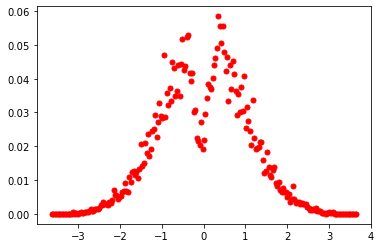

In [5]:
plt.plot(x, freq*y, 'ro', ms=5);

The curve $g(x)\Lambda(x)$, which multiplies the steady-state beginning-of-period density by the hazard rate $\Lambda(x)$, is the theoretical counterpart that we want to match this density.

We will choose $\Lambda(x)$, and the standard deviation $\sigma_\epsilon$ of shocks $\epsilon \sim \mathcal{N}(0,\sigma_\epsilon^2)$ to the ideal price, to achieve a good fit.

(One should note that these price changes, obtained from data generously provided by [Bonomo et al. (2022)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3590402), are *standardized* price changes (divided by the standard deviation of price changes within each store, then aggregated). Due to this standardization, the scale of price changes plotted here has no direct meaning within the model. The procedure in this notebook to obtain the pass-through matrix and generalized Phillips curve, however, is invariant to rescaling of all price changes, so the scaling of the data is not relevant for us.)

## Step 1a: mapping from hazard function $\Lambda$ and shock size $\sigma_\epsilon$ to steady-state density $g$
To do this, first we need to obtain the mapping from $\Lambda$ and $\sigma_\epsilon$ to $g(x)$.

We'll do this in a few parts. First, we'll make a function `forward_mapping` that takes in $\Lambda$ and $\sigma_\epsilon$ and produces a function that iterates forward on densities $g$ of price gaps on $[-\bar{x},\bar{x}]$, where $\bar{x}$ is some bound beyond which price gaps are so rare that we'll ignore them. (This may look a little scary with all the nested functions, but conceptually it's not so bad.)

Under the hood, this function is using Gauss-Legendre quadrature (inside `integrate`) and Gauss-Hermite quadrature (inside `expectations_normal`) to do integration.

In [6]:
def forward_mapping(Lambda, sigma_eps, xbar):
    """Return mapping T from g to g_+ corresponding to forward iteration on beginning-of-period densities"""
    def T(g):
        # frequency of price adjustment is integral of Lambda(x)*g(x)
        freq = 2*utils.integrate(lambda x: Lambda(x)*g(x), 0, xbar)
        
        def gplus(xs):
            # if at x' today, take expectation over (1-Lambda(x))*g(x) for x ~ N(x', sigma_eps)
            # this gives component of density coming from yesterday's non-resetters
            noreset = utils.expectations_normal(lambda x: (1-Lambda(x))*g(x), xs, sigma_eps)
            
            # add freq times density N(0, sigma_eps), from yesterday's resetters
            reset = freq*utils.normal_pdf(xs, sigma_eps)
            
            return noreset + reset
        
        return gplus
    return T

Now we look for the implied steady-state density $g(x)$. Since $g$ is some arbitrary smooth function, we need some way to represent it. We'll use a cubic spline with many interpolation nodes, and repeatedly iterate forward—calculating the next period's density at each node and then interpolating again—until successive iterations are close enough. (Note that we could economize on our representation of $g$ by exploiting symmetry $g(x)=g(-x)$, but for simplicity we simply represent $g$ as a cubic spline on the full interval $[-\bar{x},\bar{x}]$.)

One detail: because the cubic spline and numerical integration have some (slight) error, our iteration does not perfectly preserve the integral of probability density. To guarantee convergence we need to re-normalize the integral to one on each iteration.

In [7]:
def g_from_Lambda(Lambda, sigma_eps, xbar, Ncubic=200, tol=1E-8, maxit=200):
    T = forward_mapping(Lambda, sigma_eps, xbar)
    
    # grid for xs, and initial guess that the density is a uniform
    xs = np.linspace(-xbar, xbar, Ncubic)
    g = lambda x: 1/(2*xbar)
    
    # each iteration: 
    for it in range(maxit):
        # apply mapping and evaluate at xs
        gxs_new = T(g)(xs)

        # obtain new interpolated g, normalize to ensure integral of 1
        graw = interpolate.CubicSpline(xs, gxs_new)
        gint = graw.integrate(-xbar, xbar)
        g = lambda x: graw(x) / gint
        
        if it > 0 and np.max(np.abs(gxs_new - gxs)) < tol:
            return g
        elif it < maxit-1:
            gxs = gxs_new
            
    raise ValueError(f'No convergence error is {np.max(np.abs(gxs_new - gxs))}!')

## Step 1b: obtain $\Lambda$ and $\sigma_\epsilon$ that fit price change distribution
First, we need to parametrize $\Lambda$. There are many possible choices, but as mentioned in the paper we have found that the following is a useful form:

$$
\log\left(\frac{\Lambda(x)}{1-\Lambda(x)}\right) = p(x) - s\phi_\sigma(x)
$$

Here, $p(x)\equiv p_0 + p_2x^2$ is an even polynomial of degree 2, $\phi_\sigma(x)$ is the pdf of a symmetric normal distribution with standard deviation $\sigma$, and $s$ is a scaling factor. The $\phi_\sigma$ term, can be used to depress the hazard rate locally around zero price gap, is necessary to match the empirical dip in the density of adjustments around zero.

The following function implements this parametrization, returning $\Lambda(x)$ from the vector of parameters $(p_0,p_2,s,\sigma)$. We note that if $\log \frac{\Lambda(x)}{1-\Lambda(x)} = h(x)$, then $\Lambda(x) = \frac{1}{1+e^{-h(x)}}$.

In [8]:
def Lambda_from_params(params):
    p0, p2, s, sigma = params
    h = lambda x: p0 + p2*x**2 - s*utils.normal_pdf(x, sigma)
    return lambda x: 1/(1+np.exp(-h(x)))

Now, we write a function that obtains the density $g(x)\Lambda(x)$ of price changes from the full parameter vector $(\sigma_\epsilon, p_0,p_2,s,\sigma)$ and compares to the implied density in the data, returning the error.

Here, we'll choose $\bar{x}=5$, since in the data we're trying to match there are zero log price changes larger than about 3.65, and in a well-fitting model, it is quite unlikely that truncating at $[-5,5]$ will make a difference.

In [9]:
xbar = 5
def errors_from_params(params, verbose=False):
    if verbose:
        print(params)
        
    sigma_eps, *params_Lambda = params
    Lambda = Lambda_from_params(params_Lambda)
    
    if Lambda(xbar) < 0.8:
        # guide optimizer away from region where Lambda is still low at xbar, where fit is bad
        return np.full(len(x), 1E6)
    
    g = g_from_Lambda(Lambda, sigma_eps, xbar)
    err = g(x)*Lambda(x) - freq*y
    
    if verbose:
        print(np.linalg.norm(err))
    return err

Finally, we solve for the coefficients that deliver the least-squares fit, using the Levenberg-Marquardt method (`method='lm'`) starting from an arbitrary guess. This will take several seconds, and we can monitor the progress if desired by setting `verbose` to True. If you want it to run more quickly, you can uncomment the second line for `guess`, which is chosen to be very close to the optimal parameter vector.

In [10]:
guess = [0.25, -1, 1, 1, 0.1]
#guess = [0.32767304, -2.22131734, 0.63390869, 0.48661603, 0.17939816]

optimized = optimize.least_squares(errors_from_params, 
                guess, method='lm', kwargs={'verbose': False})
optimized.success

True

Now that we've found the best-fitting parameters, let's obtain the relevant $\Lambda(x)$ and $g(x)$ and plot the fit against the empirical price change distribution:

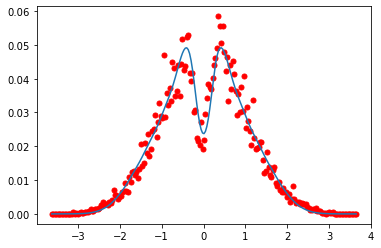

In [11]:
params = optimized.x
sigma_eps = params[0]

Lambda = Lambda_from_params(params[1:])
g = g_from_Lambda(Lambda, sigma_eps, xbar)

plt.plot(x, freq*y, 'ro', ms=5)
plt.plot(x, g(x)*Lambda(x));

It's a pretty good fit! We can also look at the accompanying hazard rate:

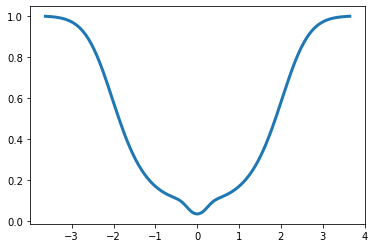

In [12]:
plt.plot(x, Lambda(x), linewidth=3);

We can also recover the implied price adjustment frequency, which will be very close to (but not exactly the same as, since we didn't achieve a perfect fit) `freq`:

In [13]:
freq_model = integrate.quad(lambda x: g(x)*Lambda(x), -xbar, xbar, epsabs=1E-13)[0]
freq_model, freq

(0.11317634641453539, 0.1141)

Finally, as an aside, it is possible to show that the model obeys a simple "conservation of variance" identity $\text{Var}(\Delta p_{it})=\sigma_\epsilon^2$, i.e. that the variance of all price changes equals the variance of innovations to ideal price. Verifying this numerically:

In [14]:
variance_all_price_changes = 2*integrate.quad(lambda x: g(x)*Lambda(x)*x**2, 0, xbar, epsabs=1E-13)[0]
variance_all_price_changes, sigma_eps**2

(0.10736564598070225, 0.10736566758061913)

One variation on our calibration strategy above would be to use this identity to infer $\sigma_\epsilon^2$ directly from the data, reducing the number of parameters in our nonlinear least squares routine by one.

# Step 2: obtain pass-through matrix and generalized Phillips curve from law of motion for price gaps
We now know how price gaps $x$ behave, since we know both the (fitted) hazard rate of adjustment back to 0, $\Lambda(x)$, and also the distribution of innovations $\epsilon\sim \mathcal{N}(0,\sigma_\epsilon^2)$.

Armed with this knowledge, we can calculate the expectation function $E^t(x)$ and then implement the formula from Proposition 6 in the paper to obtain the pass-through matrix $\Psi$, which then determines the generalized Phillips curve through the usual formula $\mathbf{K} = (\mathbf{I}-\mathbf{L})\mathbf{\Psi}(\mathbf{I}-\mathbf{\Psi})^{-1}$.

## Step 2a: compute expectation functions
In the paper, we define the expectation function $E^t(x)$ as follows: if the *end of period* price gap today is $x$, what is the expected price gap in $t$ periods?

To implement this, we define the following `expectation_mapping` function. This function, given $\Lambda$ and $\sigma_\epsilon$, produces an operator $T$ that takes expectations, given the end-of-period $x$ today, of some function $m(x')$ tomorrow.

The expectation function $E^t(x)$ is simply this operator applied $t$ times to the identity function.

In [15]:
def expectation_mapping(Lambda, sigma_eps):
    """Return mapping T from function m(x') of tomorrow's end-of-period x'
    to expectation E[m(x')|x] conditional on today's end-of-period x"""
    
    def T(m):
        def Em(xs):
            # if at x, take expectation over (1-Lambda(x'))m(x') for x' ~ N(x, sigma_eps)
            # this gives component of expectation from tomorrow's non-resetters
            noreset = utils.expectations_normal(lambda xp: (1-Lambda(xp))*m(xp), xs, sigma_eps)
            
            # take expectation over Lambda(x') to get total adj prob, multiply by m(0)
            # this gives component of expectation from tomorrow's resetters
            reset = m(0)*utils.expectations_normal(lambda xp: Lambda(xp), xs, sigma_eps)
            
            return noreset + reset
        return Em
    return T

Note that this is closely related to the previous `forward_mapping`. Indeed, in general forward iteration on the distribution and backward iteration on expectations are "transpose" operations (viewed as linear operators, they are literally transposes of each other).

In this case, however, our forward iteration is over *beginning-of-period* densities (after the realization of the shock $\epsilon$ but prior to adjustment), whereas our expectation iteration is over *end-of-period* expectations (after any adjustment has been made). This requires that we write separate code for each.

(Like with forward iteration, further optimization would be possible here: the $E^t$ are odd and it is unnecessary to represent them on the full interval $[-\bar{x},\bar{x}]$ rather than $[0,\bar{x}]$. Also, because they are odd, the contribution from the `reset` term inside `expectation_mapping` is zero. Here, we opt for the more general code.)

First let's apply `expectation_mapping` to the $\Lambda$ and $\sigma_\epsilon$ that we've found:

In [16]:
Texp = expectation_mapping(Lambda, sigma_eps)

Now, we will repeatedly apply `Texp` to iteratively take expectations, starting with the identity $E^0(x) = x$, and storing the cubic spline interpolants.

In [17]:
xs = np.linspace(-xbar, xbar, 1000)

T = 50
Es = []
Exs = xs # initialize with identity

for t in range(T):
    Et = interpolate.CubicSpline(xs, Exs)
    Exs = Texp(Et)(xs)
    Es.append(Et)

We see that by the end of our iteration, the functions have converged to almost zero, so in practice this seems to be enough:

In [18]:
np.max(np.abs(Es[T-1](xs)))

2.794469456429628e-07

For fun, let's plot the first few expectation functions and see what they look like:

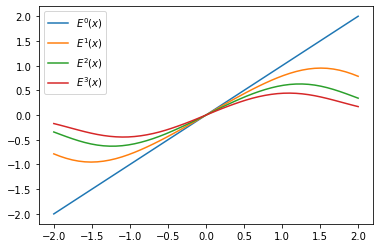

In [19]:
xs_plot = np.linspace(-2, 2, 50)
for t in range(4):
    plt.plot(xs_plot, Es[t](xs_plot), label=fr'$E^{t}(x)$')
plt.legend();

## Step 2b: use expectation functions and formula to obtain pass-through matrix

#### Intensive margin
The simpler part is the intensive margin, where we need to calculate the intensive margin virtual survival $\Phi_t^i = E^{t\prime}(0)$ as in the simpler model.

To do this, we simply iterate over $t$ and evaluate each the differentiated cubic spline at 0:

In [20]:
Phi_intensive = np.array([Et.derivative()(0) for Et in Es])

Let's quickly plot the hazard function, where we see the same increasing pattern and asymptote as in the simpler model (beyond this, survival is small enough that numerical error starts to kick in):

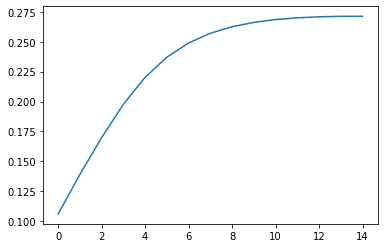

In [21]:
plt.plot(1-Phi_intensive[1:16]/Phi_intensive[:15]);

We can translate this into the intensive component of the pass-through matrix using standard code for time-dependent models:

In [22]:
beta = 0.99**(1/3) # quarterly beta=0.99 from paper, translated to monthly

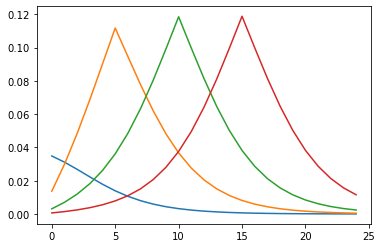

In [23]:
TPsi = 1600
Psi_intensive = utils.Psi_for_td(Phi_intensive, beta, TPsi)
plt.plot(Psi_intensive[:25, [0, 5, 10, 15]]);

As the formula in Proposition 6 points out, this is weighted in the expression for overall model $\Phi$ by $\left(\text{freq}\cdot\sum_{t=0}^\infty E^{t\prime}(0)\right)$, where $E^{t\prime}(0) = \Phi_t^i$. Hence, we can easily calculate this weighting as:

In [24]:
weight_intensive = freq_model*Phi_intensive.sum()
weight_intensive

0.6097168847918119

This implies that in the mixture of TD models that is equivalent to the underlying menu cost model, the intensive margin alone has about 61% of the weight.

#### Extensive margin
The more complex part is the extensive margin, where we need to implement the second part of the formula from Proposition 6 in the paper, which is a mixture of a continuum of pass-through matrices $\Psi^{\Phi^e(x)}$, which each correspond to the extensive margin at a particular $x$:

$$
\Psi^e = \int \Lambda'(x)g(x)\cdot \left(\sum_{t=0}^\infty E^t(x)\right)\Psi^{\Phi^e(x)}dx
$$

How will we implement this integral? We'll evaluate the integrand at a set of Gauss-Legendre quadrature nodes on $[0,\bar{x}]$, making use of the evenness of the function.

First, let's get these nodes and the corresponding weights:

In [25]:
wl, xl = utils.legendre_quick(60, 0, xbar)

Now, we want to calculate the $x$-specific virtual survival function $E^t(x)$ for all $t$ and nodes $x$. We can write:

In [26]:
Et_x = np.empty((len(Es), len(xl)))
for t, Et in enumerate(Es):
    Et_x[t, :] = Et(xl)

The weight at each $x$ is $\Lambda'(x)g(x)\sum_{t=0}^\infty E^t(x)$. First we obtain $\Lambda'(x)$ by two-sided numerical differentiation, then form the product, multiplying by 2 since we're only integrating over $[0,\bar{x}]$ rather than $[-\bar{x},\bar{x}]$:

In [27]:
Lambdap_x = (Lambda(xl+1E-4) - Lambda(xl-1E-4))/2E-4
weight_x = 2*Lambdap_x*g(xl)*Et_x.sum(axis=0)

Plotting the weight (using symmetry to show the full interval), we see that weight dips down to zero at $x=0$, as $\Lambda'(0)=0$: there is locally no relevant "extensive margin" in response to shocks at exactly $x=0$, since symmetry means that shocks in either direction don't change the probability of adjustment $\Lambda(x)$. But there is very high weight further away from 0, where $\Lambda(x)$ changes rapidly.

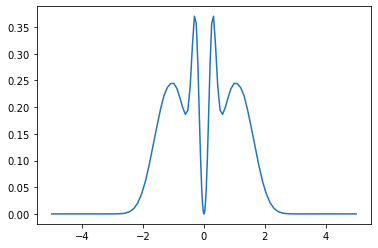

In [28]:
plt.plot(np.concatenate((-xl[::-1], xl)),
         np.concatenate((weight_x[::-1], weight_x)));

We have $\Phi_t^e(x)=E^t(x)/x$, which is easy to form:

In [29]:
Phit_x = Et_x / xl

Each column of `Phit_x` gives the virtual survival function $\Phi^e(x)$ for an individual node $x$.

For fun, we can plot the corresponding virtual hazards and see how they all converge to the same level as the intensive margin virtual hazard from above, despite starting from very different levels. The extremely high initial hazards correspond to large $|x|$, while the lowest ones correspond to very small $|x|$; as we can see above, both receive fairly low weight.

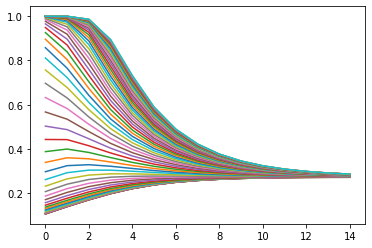

In [30]:
plt.plot(1-Phit_x[1:16, :]/Phit_x[:15, :]);

Now, we would like to form $\Psi^{\Phi^e(x)}$ for each $x$ and then take the weighted sum to obtain the integral.

Since we want high-dimensional $\Psi$ to obtain a good approximation to the $\mathbf{K}$, however, this could be a little costly. Instead, we can work with a linear transformation of the entries of $\Psi$, the corresponding "fake news matrix" $F$ (for more on this concept, see [Auclert, Bardoczy, Rognlie, Straub, Econometrica 2021](http://mattrognlie.com/sequence_space_jacobian.pdf)).

This has an especially simple rank-one form for time-dependent models, with each entry $F_{ts}$ proportional to $\Phi_t \beta^s \Phi_s$, and the sum of all entries equal to one. Importantly, this means that $F_{ts}$ will be zero beyond the point where $\Phi_t$ and $\Phi_s$ have been cut off to be zero, so that we can work with a much smaller matrix.

Fake news matrices are related to the actual $\Psi$ according to the recursion $\Psi_{t,s} = \Psi_{t-1,s-1} + F_{t,s}$, with base case $\Psi_{t,s} = F_{t,s}$ when $t=0$ or $s=0$.

First, let's build the fake news matrices for each $x$, iterating over the columns `Phit` of `Phit_x`:

In [31]:
F_x = [utils.F_for_td(Phit, beta) for Phit in Phit_x.T]

Now, we can aggregate these by both the weights in the integrand and the quadrature weights to get the fake news matrix corresponding to the overall pass-through matrix:

In [32]:
F_extensive = sum(w*weight*F for w, weight, F in zip(wl, weight_x, F_x))

We can then translate to the actual, much larger $\Psi$ matrix:

In [33]:
Psi_extensive = utils.J_from_F(F_extensive, T=TPsi)

If we want to know the total "weight" of the extensive margin in the mixture (equivalent to the long-term extensive-margin price response to a permanent shock), we can numerically integrate the weights from before.

In [34]:
weight_extensive = wl @ weight_x

The sum of all entries of the fake news matrix also gives the weight:

In [35]:
weight_extensive_alt = F_extensive.sum()
weight_extensive, weight_extensive_alt

(0.39481348528912774, 0.3948134852891277)

We'll normalize by weight to put `Psi_extensive` and `Psi_intensive` on the same footing (i.e. both pass-through matrices are defined so that they correspond to models where the overall pass-through of costs to prices a sufficiently anticipated shock is 1):

In [36]:
Psi_extensive /= weight_extensive

In [37]:
# combined pass-through to prices of shocks enough in future (50+) is 1
Psi_intensive.sum(axis=0)[50:55], Psi_extensive.sum(axis=0)[50:55], 

(array([1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1.]))

Finally, let's plot `Psi_extensive`. Compared to `Psi_intensive` above, we see somewhat higher, sharper peaks, corresponding to a more elastic extensive margin.

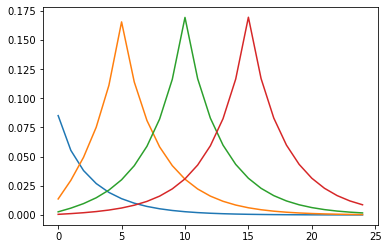

In [38]:
plt.plot(Psi_extensive[:25, [0, 5, 10, 15]]);

## Step 2c: obtain generalized Phillips curve from pass-through matrix
First, we'll aggregate the intensive and extensive $\Psi$, multiplying both by their weights, and adjusting for the fact that for numerical reasons, the weights nearly but do not exactly sum to 1:

In [39]:
Psi = (weight_intensive*Psi_intensive + weight_extensive*Psi_extensive)/(weight_intensive + weight_extensive)
weight_intensive + weight_extensive

1.0045303700809396

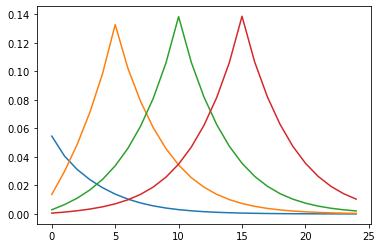

In [40]:
plt.plot(Psi[:25, [0, 5, 10, 15]]);

Now, we'll obtain the generalized Phillips curve by directly implementing $\mathbf{K} = (\mathbf{I}-\mathbf{L})\Psi(\mathbf{I}-\Psi)^{-1}$. (Note that truncation here causes artifacts, so we need to choose a very large `TPsi`, in this case 1600.)

In [41]:
# calculate (I-Psi)^(-1)Psi, same as Psi(I-Psi)^(-1)
K = np.linalg.solve(np.eye(TPsi) - Psi, Psi)

# multiply by (I-L), i.e. subtract lagged rows
K[1:, :] -= K[:-1, :]

Now let's plot some columns of the generalized Phillips curve matrix:

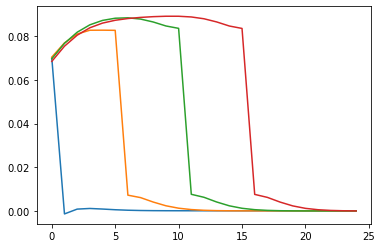

In [42]:
plt.plot(K[:25, [0, 5, 10, 15]]);

We note that these look close to the traditional Calvo New Keynesian Phillips curve, but do display a few non-Calvo features: slight persistence after the real marginal cost shock and stronger anticipation immediately beforehand, and less response immediately on impact.

We should also note, however, that this is at a *monthly* frequency, and in the paper more generally we look at shocks at a horizon of 10 or 20 quarters (in addition to a date-0 shock), which translates to 30 or 60 months. Plotting these longer-dated shocks, the impulses look very similar to the standard NKPC:

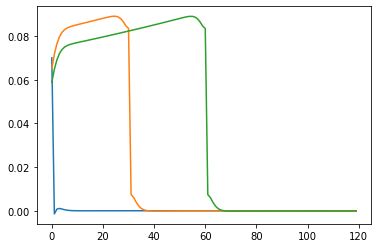

In [43]:
plt.plot(K[:120, [0, 30, 60]]);

We can also calculate the GPC that would be implied by only the intensive-margin part of the mixture, where we see similar but more pronounced departures from Calvo:

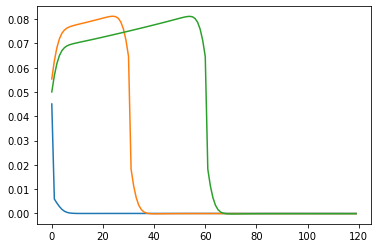

In [44]:
K_intensive = np.linalg.solve(np.eye(TPsi) - Psi_intensive, Psi_intensive)
K_intensive[1:, :] -= K_intensive[:-1, :]
plt.plot(K_intensive[:120, [0, 30, 60]]);

Proceeding similarly with the extensive margin, we get opposite behavior—with antipersistence—consistent with what we find in Figure 10 of the paper.

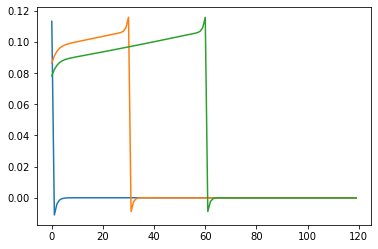

In [45]:
K_extensive = np.linalg.solve(np.eye(TPsi) - Psi_extensive, Psi_extensive)
K_extensive[1:, :] -= K_extensive[:-1, :]
plt.plot(K_extensive[:120, [0, 30, 60]]);

Importantly, however, this departure from Calvo for the extensive margin is less stark than we see in the paper's Figure 10 for our baseline "Golosov-Lucas" and "Nakamura-Steinsson" models, especially the latter. This is because the extensive margin here is a mixture of separate "extensive margins" for all $x$, and not all of these have the rapidly declining virtual hazards that are characteristic of the extensive margin in the basic menu cost model. Also, the extensive margin receives less weight here than in the Golosov-Lucas calibration.

For these reasons—lower weight, and a smaller departure from Calvo—the extensive margin affects the mixture less than in our baseline models, allowing the intensive margin to play a larger role. This leads the overall generalized Phillips curve to have some features associated with the intensive margin and its increasing virtual hazard—most distinctively, a slight amount of persistence. Quantitatively, however, it is still very similar to the Calvo NKPC.